In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# !pip install -Uqq ipdb
# import ipdb

In [ ]:
# generating ranbdom functions
def random_functions(rho, num_steps, num_paths, T):
  dt = T / (num_steps) # time steps
  dW = np.random.normal(0, np.sqrt(dt), (num_paths, num_steps))
  dW_perp = np.random.normal(0, np.sqrt(dt), (num_paths))
  dWq = rho * dW[:, num_steps - 1] + np.sqrt(1 - rho ** 2) * dW_perp


  return dt, dW, dW_perp, dWq

Brownian motion

In [ ]:
# generate the path for the stock
# S0: the initial price
# rf: the risk-free interest rate
# q: the dividend yield of the stock
# sigma_s: the volatility of the stock
# num_paths: the number of paths to simulate
# num_steps: the number of steps in each path
# time_steps: the time step for each step
# rho_sx: the correlation between the stock and another asset
# sigma_x: the volatility of the other asset
def stock_path(S0, rf, q, sigma_s, num_paths, num_steps, dt, rho_sx, sigma_x):
  S = np.zeros((num_paths, num_steps + 1))
  S[:, 0] = S0

  drift_stock = rf - q - rho_sx * sigma_s * sigma_x
  dW = np.random.normal(0, np.sqrt(dt), (num_paths, num_steps))

  for step in range(num_steps):
      S[:, step + 1] =  S[:, step] * np.exp(drift_stock * dt - 0.5 * sigma_s**2 * dt + sigma_s * dW[:, step])

  return S

# generate the path for the interest by hull-white model
def interest_path(r0, theta, a, sigma, dW, dt, num_paths, num_steps, dWq, rho_sr):
  r = np.zeros((num_paths, num_steps + 1))
  r[:, 0] = r0

  for t in range(num_steps):
    drift_interest = theta - a * r[:, t]
    # r[:, t + 1] = r[:, t] + drift_interest * dt + sigma * dWq
    r[:, t+1] = r[:, t] + (theta - a * r[:, t]) * dt + sigma * (rho_sr * dW[:, t] + np.sqrt(1 - rho_sr**2) * np.random.normal(0, np.sqrt(dt),num_paths))

  return r

In [ ]:
#%pdb on

In [ ]:
# calculate the zero-coupon bond price by hull-white
def Hull_White_bp(price1, price2, forward_rate, a, sigma, t, T, r):
  p = price1 / price2
  B = (1 - np.exp(-a * (T - t))) / a
  e = np.exp(B * forward_rate - (sigma**2 / 4*a) * (B**2) * (1 - np.exp(-2*a*t)) - B * r[:,-1] )
  bp = p * e

  return bp

# calculate LIBOR rate
def libor(price1, price2, delta):
  lib = (price1 - price2) / (delta * price2)

  return lib

#the contract function
def calpayoff(k,k_prime,S ,L_delta,L_T):
  s_ratio = S[:, -1] / S[:, 0]
  print("s_ratio", s_ratio)
  L_ratio = L_delta / L_T
  print("L_ratio", L_ratio)
  payoff = np.maximum(0,(s_ratio - k) * (k_prime - L_ratio))
  return payoff

L_delta [0.02738924 0.0317827  0.05774099 ... 0.08452997 0.04274118 0.05897033]
s_ratio [1.35239423 0.47867466 1.44862081 ... 0.85909675 2.53318235 0.71540962]
L_ratio [0.79978468 0.92807673 1.68607684 ... 2.46833352 1.24807205 1.72197431]
expected payoff 0.2152314247999659
present value 0.21685172903166555


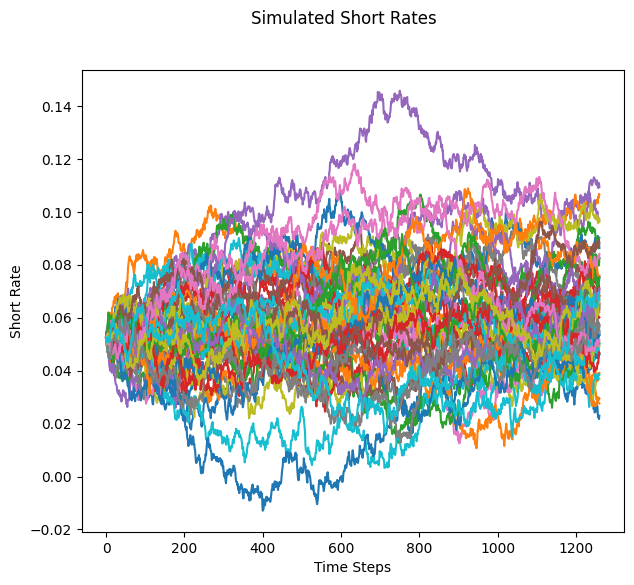

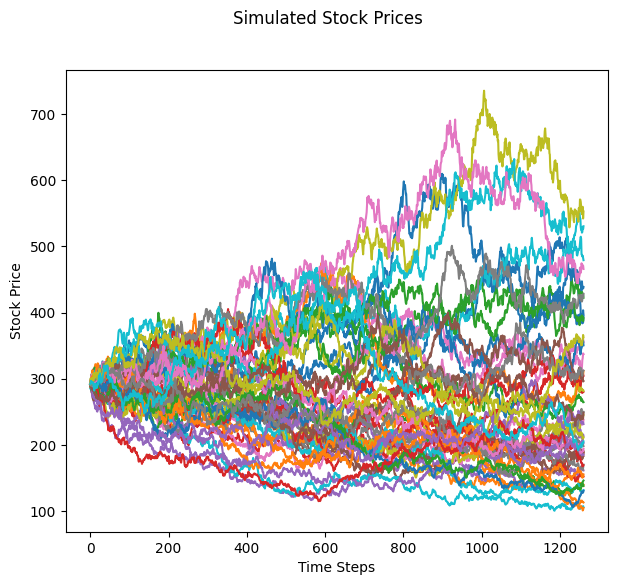

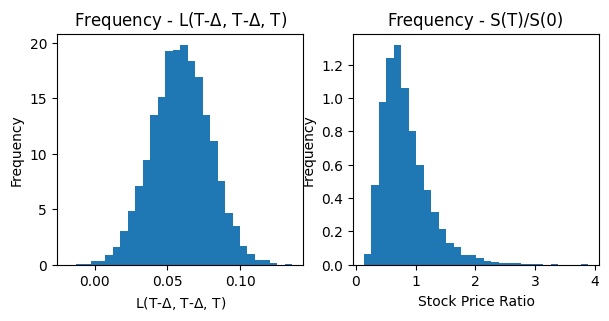

In [ ]:
# for the actual price
k = 1
k_prime = 1
S0 = 291.57
rf = -0.0015
r0 = 0.0525
theta = 0.03
a = 0.5
sigma_r = 0.02
q = 0.0152
rho_sr = 0.6
rho_sx = 0.5
sigma_s = 0.2
sigma_x = 0.18
T = 5 #5 years
num_steps = 252 * 5 #time step : every day
num_paths = 10000

delta = 1 / 4 #3 month (1/4 year)
P_0_T = np.exp(-0.0341 * 5) # 0.0336 is the 5 year treasury yield (looked up)
P_0_t = np.exp(-0.0341 * (5 - 0.25)) # we consider 5 year yield and 5 - 3 month yield to be similar
forward_rate = 0.030215


dt, dW, dW_perp, dWq = random_functions(rho_sr, num_steps, num_paths, T)

s = stock_path(S0, rf, q, sigma_s, num_paths, num_steps,  dt, rho_sx, sigma_x)
r = interest_path(r0, theta, a, sigma_r, dW, dt, num_paths, num_steps , dWq, rho_sr)

p_delta_T = Hull_White_bp(P_0_T,P_0_t,forward_rate,a,sigma_r,T-delta,T,r)


L_delta = libor(1,p_delta_T,delta)

L_T = libor(P_0_t,P_0_T,delta)

# print('LIBOR', L_T)
print('L_delta', L_delta)

# print('stock', s)
# print('interest rate', r)

payoff = calpayoff(k,k_prime,s,L_delta,L_T)
expected_payoff = np.mean(payoff)
present_value = expected_payoff * np.exp(-rf * T)

# ipdb.set_trace(context = 28)
print('expected payoff', expected_payoff)
print('present value', present_value)

plt.fig = plt.subplots(figsize=(7, 6))
plt.plot(r[:50].T)
plt.suptitle("Simulated Short Rates")
plt.xlabel("Time Steps")
plt.ylabel("Short Rate")
plt.show()

plt.fig = plt.subplots(figsize=(7, 6))
plt.plot(s[:50].T)
plt.suptitle("Simulated Stock Prices")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.show()

# fig, ax = plt.subplots(figsize=(7, 6))
# ax.plot(r[:, -2])
# ax.set_title("Frequency - L(T-Delta, T-Delta, T)")
# ax.set_xlabel(r"$L(T-Delta, T-Delta, T)$")
# ax.set_ylabel("Frequency")
# plt.show()


# Histograms of L(T-Delta, T-Delta, T) and S(T)/S(0)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

# Histogram for L(T-Delta, T-Delta, T)
L_T_Delta = r[:, -2]
axes[0].hist(L_T_Delta, bins=30, density=True)
axes[0].set_title("Frequency - L(T-$\Delta$, T-$\Delta$, T)")
axes[0].set_xlabel("L(T-$\Delta$, T-$\Delta$, T)")
axes[0].set_ylabel("Frequency")

# Histogram for S(T)/S(0)
S_ratio = s[:, -1] / s[:, 0]
axes[1].hist(S_ratio, bins=30, density=True)
axes[1].set_title("Frequency - S(T)/S(0)")
axes[1].set_xlabel("Stock Price Ratio")
axes[1].set_ylabel("Frequency")

plt.show()


L_delta [0.07510064 0.0297186  0.04095102 ... 0.05754532 0.04644485 0.05996657]
s_ratio [0.62464949 0.5392192  0.57598193 ... 0.47630946 0.82716531 0.49234771]
L_ratio [2.19299052 0.86780355 1.19579794 ... 1.68036302 1.3562218  1.75106524]
expected payoff 0.20951244382137352
present value 0.2202543765205155


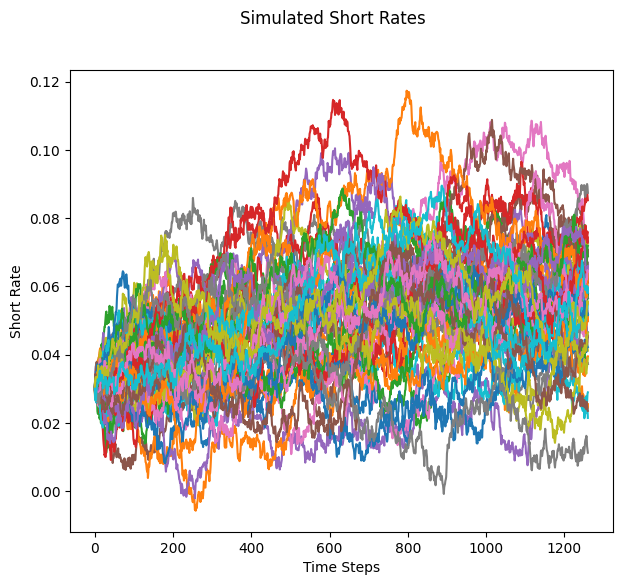

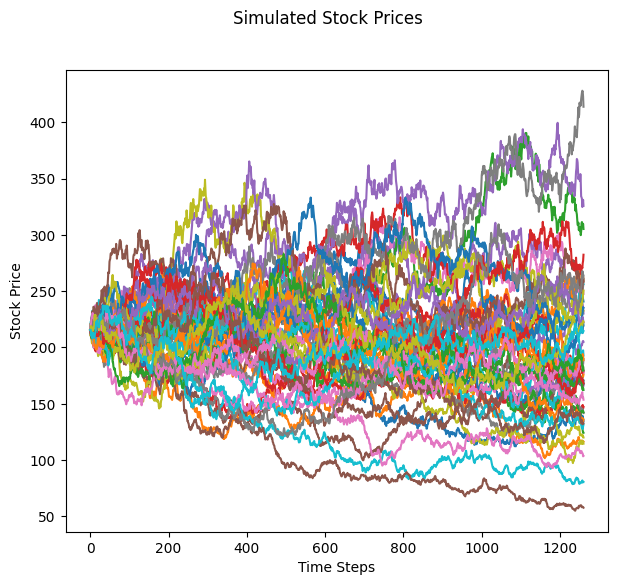

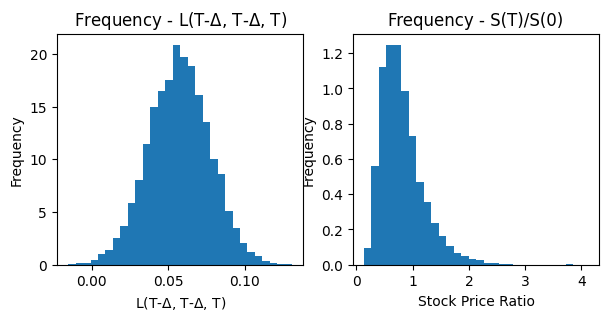

In [ ]:
# for the given data
k = 1
k_prime = 1
S0 = 215.69
rf = -0.01
r0 = 0.03
theta = 0.03
a = 0.5
sigma_r = 0.02
q = 0.0152
rho_sr = 0.6
rho_sx = 0.5
sigma_s = 0.2
sigma_x = 0.15
T = 5 #5 years
num_steps = 252 * 5 #time step : every day
num_paths = 10000

delta = 1 / 4 #3 month (1/4 year)
P_0_T = np.exp(-0.0341 * 5) # 0.0336 is the 5 year treasury yield (looked up)
P_0_t = np.exp(-0.0341 * (5 - 0.25)) # we consider 5 year yield and 5 - 3 month yield to be similar
forward_rate = 0.030215


dt, dW, dW_perp, dWq = random_functions(rho_sr, num_steps, num_paths, T)

s = stock_path(S0, rf, q, sigma_s, num_paths, num_steps,  dt, rho_sx, sigma_x)
r = interest_path(r0, theta, a, sigma_r, dW, dt, num_paths, num_steps , dWq, rho_sr)

p_delta_T = Hull_White_bp(P_0_T,P_0_t,forward_rate,a,sigma_r,T-delta,T,r)


L_delta = libor(1,p_delta_T,delta)

L_T = libor(P_0_t,P_0_T,delta)

# print('LIBOR', L_T)
print('L_delta', L_delta)

# print('stock', s)
# print('interest rate', r)

payoff = calpayoff(k,k_prime,s,L_delta,L_T)
expected_payoff = np.mean(payoff)
present_value = expected_payoff * np.exp(-rf * T)

# ipdb.set_trace(context = 28)
print('expected payoff', expected_payoff)
print('present value', present_value)

plt.fig = plt.subplots(figsize=(7, 6))
plt.plot(r[:50].T)
plt.suptitle("Simulated Short Rates")
plt.xlabel("Time Steps")
plt.ylabel("Short Rate")
plt.show()

plt.fig = plt.subplots(figsize=(7, 6))
plt.plot(s[:50].T)
plt.suptitle("Simulated Stock Prices")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.show()

# fig, ax = plt.subplots(figsize=(7, 6))
# ax.plot(r[:, -2])
# ax.set_title("Frequency - L(T-Delta, T-Delta, T)")
# ax.set_xlabel(r"$L(T-Delta, T-Delta, T)$")
# ax.set_ylabel("Frequency")
# plt.show()


# Histograms of L(T-Delta, T-Delta, T) and S(T)/S(0)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

# Histogram for L(T-Delta, T-Delta, T)
L_T_Delta = r[:, -2]
axes[0].hist(L_T_Delta, bins=30, density=True)
axes[0].set_title("Frequency - L(T-$\Delta$, T-$\Delta$, T)")
axes[0].set_xlabel("L(T-$\Delta$, T-$\Delta$, T)")
axes[0].set_ylabel("Frequency")

# Histogram for S(T)/S(0)
S_ratio = s[:, -1] / s[:, 0]
axes[1].hist(S_ratio, bins=30, density=True)
axes[1].set_title("Frequency - S(T)/S(0)")
axes[1].set_xlabel("Stock Price Ratio")
axes[1].set_ylabel("Frequency")

plt.show()
